# Multi-Omics Analysis for LUSC Survival Prediction

Bla



## Imports and helper functions

In [1]:
import os
import shutil
import io
import glob
import requests
import json
import tarfile
import random
import warnings
import functools
import re

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import lifelines

import sklearn
from sklearn.preprocessing import scale, minmax_scale, robust_scale
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, classification_report
from sklearn.feature_selection import SelectKBest, f_classif

from pypgatk.cgenomes.cbioportal_downloader import CbioPortalDownloadService

In [2]:
# Set the random seeds
seed = 0
torch.random.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
dim_reduction = TSNE
dim_reduction_label = "TSNE_{}"

### Data acquisition and reading

In [4]:
def untar_study(study, output_directory, fmt=".tar.gz"):
    file = tarfile.open(
        os.path.join(
            output_directory,
            "{study}{format}".format(study=study, format=fmt)
            )
        )
    file.extractall(output_directory)
    file.close()

In [5]:
def download_cbioportal_study(
        config_file,
        study,
        output_directory = "./data",
        list_studies = False,
        multithreading = True,
        **kwargs
        ):
    pipeline_arguments = {
        CbioPortalDownloadService.CONFIG_OUTPUT_DIRECTORY: output_directory,
        CbioPortalDownloadService.CONFIG_LIST_STUDIES: list_studies,
        CbioPortalDownloadService.CONFIG_MULTITHREADING: multithreading,
        **kwargs,
    } 
    cbioportal_downloader_service = CbioPortalDownloadService(config_file, pipeline_arguments)
    cbioportal_downloader_service.download_study(study)

In [6]:
def get_mirna_files(
        project_id="TCGA-LUSC",
        maxfiles=10000,
        cases_endpt = "https://api.gdc.cancer.gov/files",
        data_endpt = "https://api.gdc.cancer.gov/data"
        ):


    # Retrieve associated file names
    filters = {
        "op": "and",
        "content":[
            {"op": "=",
            "content":{
                "field": "cases.project.project_id",
                "value": ["TCGA-LUSC"]
                }
            },
            {"op": "=",
            "content":{
                "field": "files.experimental_strategy",
                "value": ["miRNA-Seq"]
                }
            },
            {"op": "=",
            "content":{
                "field": "files.data_category",
                "value": ["Transcriptome Profiling"]
                }
            },
            {"op": "=",
            "content":{
                "field": "files.data_type",
                "value": ["miRNA Expression Quantification"]
                }
            }
        ]
    }

    params = {
        "filters": json.dumps(filters),
        "fields": ",".join(["cases.samples.submitter_id","file_name", "Entity ID"]),
        "format": "TSV",
        "size": str(maxfiles)
    }

    response = requests.get(cases_endpt, params = params)
    files_df = pd.read_csv(io.StringIO(response.text), sep="\t")
    return files_df

def download_mirna_files(
        files_df,
        output_directory = "./data",
        project_id="TCGA-LUSC",
        maxfiles=10000,
        cases_endpt = "https://api.gdc.cancer.gov/files",
        data_endpt = "https://api.gdc.cancer.gov/data"
        ):
    
    params = {"ids": files_df["id"].tolist()}

    response = requests.post(data_endpt,
                            data = json.dumps(params),
                            headers={
                                "Content-Type": "application/json"
                                })

    response_head_cd = response.headers["Content-Disposition"]
    file_name = re.findall("filename=(.+)", response_head_cd)[0]
    with open(os.path.join(output_directory, file_name), "wb") as output_file:
        output_file.write(response.content)
    return file_name

In [7]:
def untar_and_merge_mirna_files(
        files_df,
        file_name,
        output_directory = "./data",
        cleanup=True
        ):
    untar_study(file_name, output_directory, fmt="")
    
    miRNA_IDs = set()
    patient_dfs = {}
    patient_folders = []
    for i in range(len(files_df)):
        patient_id = files_df["cases.0.samples.0.submitter_id"].iloc[i]
        foldername = files_df["id"].iloc[i]
        patient_fname = os.listdir(os.path.join(output_directory, foldername))[0]
        patient_df = pd.read_csv(os.path.join(output_directory, foldername, patient_fname), sep="\t")
        
        miRNA_IDs.update(patient_df["miRNA_ID"].tolist())
        patient_dfs[patient_id] = patient_df
        patient_folders.append(foldername)
    
    miRNA_df = pd.DataFrame({"patient_id":[], **{k:[] for k in miRNA_IDs}}).set_index("patient_id")
    for patient_id in patient_dfs:
        patient_df = patient_dfs[patient_id]
        cbioportal_patient_id = patient_id[:-1] # This line is to match cBioPortal's format
        transposed_patient_df = patient_df[["miRNA_ID","reads_per_million_miRNA_mapped"]].set_index("miRNA_ID").transpose()
        transposed_patient_df["patient_id"] = [cbioportal_patient_id]
        transposed_patient_df = transposed_patient_df.set_index("patient_id")
        miRNA_df.loc[cbioportal_patient_id,miRNA_df.columns] = transposed_patient_df[miRNA_df.columns].values.flatten()
        
    if cleanup:
        for patient_folder in patient_folders:
            shutil.rmtree(os.path.join(output_directory, patient_folder))
    
    return miRNA_df

In [8]:
def remove_constant_columns(df):
    columns_to_remove = []
    for idx, column in enumerate(df.columns):
        try:
            if (df[column].std() == 0).any():
                columns_to_remove.append(column)
        except KeyError:
            columns_to_remove.append(column)
    return df.drop(columns=columns_to_remove)

def remove_columns_with_significant_modes(df, max_mode_pct=0.2):
    columns_to_remove = []
    for idx, column in enumerate(df.columns):
        try:
            if (df[column].value_counts(True) >= max_mode_pct).any():
                columns_to_remove.append(column)
        except KeyError:
            columns_to_remove.append(column)
    return df.drop(columns=columns_to_remove)

### Autoencoder Model

In [9]:
class MLP(nn.Module):
    def __init__(
            self,
            input_dim,
            hidden_dims,
            output_dim,
            nonlinearity,
            dropout_rate=0.5,
            bias=True
            ):
        super().__init__()
        in_dims = [input_dim] + hidden_dims
        out_dims = hidden_dims + [output_dim]
        
        self.layers = nn.ModuleList([nn.Linear(d_in, d_out, bias=bias) for d_in, d_out in zip(in_dims, out_dims)])
        self.nonlinearity = nonlinearity
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.dropout(self.nonlinearity(layer(x)))
        return self.layers[-1](x)
        

class Autoencoder(nn.Module):
    def __init__(
            self,
            input_dim,
            hidden_dims,
            encoding_dim,
            nonlinearity=F.relu,
            final_nonlinearity=lambda x:x,
            dropout_rate=0.5,
            bias=True):
        super().__init__()
        try:
            len(hidden_dims)
        except TypeError:
            hidden_dims = [hidden_dims]
        
        self.encoder = MLP(input_dim, hidden_dims, encoding_dim, nonlinearity, dropout_rate, bias)
        self.decoder = MLP(encoding_dim, hidden_dims[-1::-1], input_dim, nonlinearity, dropout_rate, bias)
        self.final_nonlinearity = final_nonlinearity
    
    def encode(self,x):
        return self.encoder(x)
    
    def decode(self,x):
        return self.final_nonlinearity(self.decoder(x))
    
    def forward(self, x):
        return self.decode(self.encode(x))

### High/Low risk estimation 

In [10]:
def kmf_high_low(df_clin, subgroups):
    target_features = df_clin.copy()
    target_features["Risk_subgroup"] = subgroups
    samples_0 = target_features[target_features["Risk_subgroup"]==0]
    samples_1 = target_features[target_features["Risk_subgroup"]==1]
    kmf_0 = lifelines.KaplanMeierFitter(label="0")
    kmf_1 = lifelines.KaplanMeierFitter(label="1")
    kmf_0.fit(durations=samples_0["OS_MONTHS"],
              event_observed=samples_0["OS_STATUS_B"])
    kmf_1.fit(durations=samples_1["OS_MONTHS"],
              event_observed=samples_1["OS_STATUS_B"])
    timeline_95 = min(np.percentile(kmf_0.survival_function_.index, 95), np.percentile(kmf_0.survival_function_.index, 95))
    pct_0 = np.percentile(kmf_0.survival_function_, 100*(1-timeline_95/max(kmf_0.survival_function_.index)))
    pct_1 = np.percentile(kmf_1.survival_function_, 100*(1-timeline_95/max(kmf_1.survival_function_.index)))
    if pct_0 > pct_1:
        kmf_low, kmf_high = kmf_0, kmf_1
        low_risk_samples, high_risk_samples = samples_0, samples_1
    else:
        kmf_low, kmf_high = kmf_1, kmf_0
        low_risk_samples, high_risk_samples = samples_1, samples_0
    kmf_low._label = "low_risk_subgroup"
    kmf_high._label = "high_risk_subgroup"
    return kmf_low, kmf_high, low_risk_samples, high_risk_samples

## Data Acquisition and Pre-Processing

### Acquiring data from cBioPortal

In [11]:
cbioportal_config = "./config/cbioportal_config.yaml"
data_directory = "./data"
study_name = "lusc_tcga"

In [12]:
#download_cbioportal_study(cbioportal_config, study_name, data_directory)

In [13]:
untar_study(study_name, data_directory, fmt=".tar")

In [14]:
clinical_data = pd.read_csv(os.path.join(data_directory, study_name, "data_clinical_patient.txt"), comment="#", sep="\t").set_index("PATIENT_ID").drop(columns="OTHER_PATIENT_ID")
clinical_data = clinical_data.set_index(clinical_data.index + "-01")
clinical_data.describe()

,FORM_COMPLETION_DATE,HISTOLOGICAL_DIAGNOSIS,PROSPECTIVE_COLLECTION,RETROSPECTIVE_COLLECTION,SEX,RACE,ETHNICITY,LATERALITY,HISTORY_OTHER_MALIGNANCY,PRIMARY_SITE_PATIENT,...,POS_LYMPH_NODE_LOCATION,PROJECT_CODE,STAGE_OTHER,TARGETED_MOLECULAR_THERAPY,TISSUE_SOURCE_SITE,SITE_OF_TUMOR_TISSUE,OS_STATUS,OS_MONTHS,DFS_STATUS,DFS_MONTHS
count,504,504,504,504,504,504,504,504,504,504,...,504,504,504,504,504,504,504,504,504,504
unique,199,1,3,3,2,4,3,1,5,9,...,1,1,1,3,35,1,2,439,3,328
top,3/7/11,Lung Squamous Cell Carcinoma,NO,YES,Male,WHITE,NOT HISPANIC OR LATINO,[Not Available],No,L-Upper,...,[Not Available],[Not Available],[Not Available],[Not Available],85,Lung,0:LIVING,2,0:DiseaseFree,[Not Available]
freq,39,504,326,326,373,351,319,504,433,137,...,504,504,504,350,50,504,284,8,245,127


In [15]:
# Drop unused columns
clinical_data = clinical_data[["OS_STATUS", "OS_MONTHS"]]
# Add a binary column with the status
clinical_data["OS_STATUS_B"] = clinical_data["OS_STATUS"]=="1:DECEASED"
clinical_data["OS_MONTHS"] = pd.to_numeric(clinical_data["OS_MONTHS"], errors="coerce")
clinical_data = clinical_data.dropna()

Cap study duration

In [16]:
study_duration = 100 * 12
clinical_data.loc[clinical_data["OS_MONTHS"]>study_duration,["OS_MONTHS", "OS_STATUS"]] = [study_duration, "0:LIVING"]

In [17]:
clinical_data[np.logical_not(clinical_data["OS_STATUS_B"])]

,OS_STATUS,OS_MONTHS,OS_STATUS_B
PATIENT_ID,,,
TCGA-18-3409-01,0:LIVING,123.09,False
TCGA-18-3411-01,0:LIVING,117.48,False
TCGA-18-3419-01,0:LIVING,92.35,False
TCGA-18-3421-01,0:LIVING,86.89,False
TCGA-18-4721-01,0:LIVING,154.20,False
...,...,...,...
TCGA-NK-A5CR-01,0:LIVING,83.51,False
TCGA-NK-A5CT-01,0:LIVING,65.60,False
TCGA-NK-A5CX-01,0:LIVING,3.65,False


In [18]:
clinical_data.describe()

,OS_MONTHS
count,498.000000
mean,31.949920
std,31.603341
min,0.000000
25%,10.682500
50%,21.895000
75%,41.382500
max,173.690000


<AxesSubplot:xlabel='timeline'>

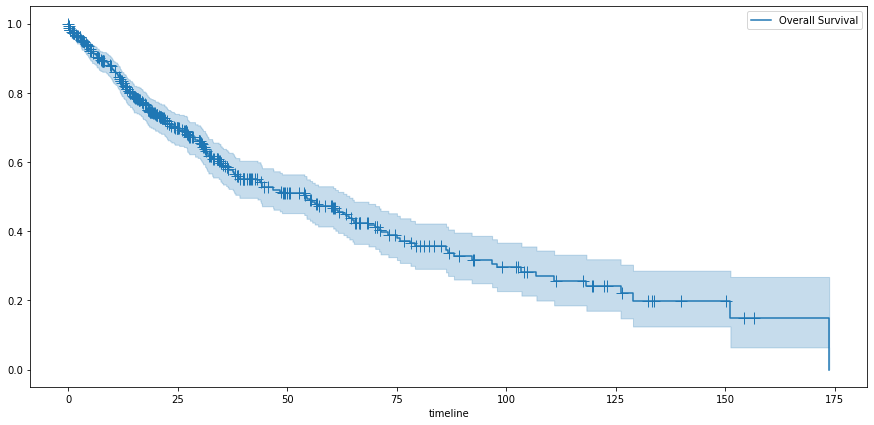

In [19]:
kmf = lifelines.KaplanMeierFitter(label="Overall Survival")
kmf.fit(durations=clinical_data["OS_MONTHS"],
        event_observed=clinical_data["OS_STATUS_B"])
plt.figure(figsize=(15,7))
kmf.plot(show_censors=1, ci_show=1)

In [20]:
#RNAseq = pd.read_csv(os.path.join(data_directory, study_name, "data_RNA_Seq_v2_expression_median.txt"), comment="#", sep="\t").set_index("Hugo_Symbol").drop(columns="Entrez_Gene_Id")
RNAseq = pd.read_csv(os.path.join(data_directory, study_name, "data_mrna_seq_v2_rsem.txt"), comment="#", sep="\t").set_index("Hugo_Symbol").drop(columns="Entrez_Gene_Id")
linearCNA = pd.read_csv(os.path.join(data_directory, study_name, "data_linear_cna.txt"), comment="#", sep="\t").set_index("Hugo_Symbol").drop(columns="Entrez_Gene_Id")
methylation_hm450 = pd.read_csv(os.path.join(data_directory, study_name, "data_methylation_hm450.txt"), comment="#", sep="\t").set_index("Hugo_Symbol").drop(columns="Entrez_Gene_Id")

RNAseq.shape[0], linearCNA.shape[0], methylation_hm450.shape[0]

(20531, 24776, 16714)

Remove any columns with a mode with more than 20% frequency

In [21]:
RNAseq_t = remove_columns_with_significant_modes(RNAseq.transpose()).dropna(axis="columns")
RNAseq_t = RNAseq_t.rename(lambda x: x+"_mrna", axis="columns")
linearCNA_t = remove_columns_with_significant_modes(linearCNA.transpose()).dropna(axis="columns")
linearCNA_t = linearCNA_t.rename(lambda x: x+"_lcna", axis="columns")
methylation_hm450_t = remove_columns_with_significant_modes(methylation_hm450.transpose()).dropna(axis="columns")
methylation_hm450_t = methylation_hm450_t.rename(lambda x: x+"_methy", axis="columns")
RNAseq_t.shape[-1], linearCNA_t.shape[-1], methylation_hm450_t.shape[-1]

(16827, 24754, 15854)

In [22]:
RNAseq_t = (RNAseq_t)
linearCNA_t = (linearCNA_t)
methylation_hm450_t = remove_columns_with_significant_modes(methylation_hm450_t)
RNAseq_t.shape[-1], linearCNA_t.shape[-1], methylation_hm450_t.shape[-1]

(16827, 24754, 15854)

Rebuild non-transposed dataframes

In [23]:
RNAseq = RNAseq_t.transpose()
linearCNA = linearCNA_t.transpose()
methylation_hm450 = methylation_hm450_t.transpose()
len(RNAseq), len(linearCNA), len(methylation_hm450)

(16827, 24754, 15854)

### miRNA data from gdc.cancer.gov

In [24]:
mirna_files_df = get_mirna_files()
mirna_files_df.describe()

,cases.0.samples.0.submitter_id,file_name,id
count,523,523,523
unique,523,523,523
top,TCGA-22-1011-01A,7df584d3-5b11-4987-8227-6d809e8305af.mirbase21...,07fa22d0-99b1-4364-9b93-d937005a2416
freq,1,1,1


In [25]:
#mirna_fname = download_mirna_files(mirna_files_df, data_directory)
#mirna_fname = "gdc_download_20211114_175949.738652.tar.gz"
mirna_fname = "gdc_download_20211118_203457.926713.tar.gz"

In [26]:
miRNA_df_t = untar_and_merge_mirna_files(mirna_files_df, mirna_fname, data_directory)
print("All columns:", len(miRNA_df_t.columns))
miRNA_df_t = remove_constant_columns(miRNA_df_t).dropna(axis="columns")
print("Only non-constant columns:", len(miRNA_df_t.columns))
miRNA_df_t = remove_columns_with_significant_modes(miRNA_df_t)
print("Only non-mode-dominant columns:", len(miRNA_df_t.columns))
miRNA_df = miRNA_df_t.transpose()
miRNA_df.to_csv("miRNA.csv", index_label="miRNA")
miRNA_df_t = miRNA_df_t.rename(lambda x: x+"_mirna", axis="columns")

All columns: 1881
Only non-constant columns: 1585
Only non-mode-dominant columns: 413


## Reconciling data from cBioPortal and gdc.cancer.gov

In [27]:
clinical_patients = set(clinical_data.index)
RNAseq_patients = set(RNAseq_t.index)
linearCNA_patients = set(linearCNA_t.index)
methylation_hm450_patients = set(methylation_hm450_t.index)
miRNA_patients = set(miRNA_df_t.index)
all_sets = [clinical_patients, RNAseq_patients, linearCNA_patients, methylation_hm450_patients, miRNA_patients]
all_patients = functools.reduce(lambda x, y: x|y, all_sets, set())
patients_on_all_datasets = functools.reduce(lambda x, y: x&y, all_sets, all_patients)

In [28]:
list(map(len, all_sets))

[498, 501, 501, 370, 523]

In [29]:
len(all_patients), len(patients_on_all_datasets)

(549, 356)

In [30]:
clinical_columns = set(clinical_data.columns)
RNAseq_columns = set(RNAseq_t.columns)
linearCNA_columns = set(linearCNA_t.columns)
methylation_hm450_columns = set(methylation_hm450_t.columns)
miRNA_columns = set(miRNA_df_t.columns)
all_col_sets = [clinical_columns, RNAseq_columns, linearCNA_columns, miRNA_columns]
all_columns = functools.reduce(lambda x, y: x|y, all_col_sets, set())
columns_on_all_datasets = functools.reduce(lambda x, y: x&y, all_col_sets, all_columns)

In [31]:
list(map(len, all_col_sets))

[3, 16827, 24754, 413]

In [32]:
len(all_columns), len(columns_on_all_datasets)

(41997, 0)

In [33]:
[(i,j,len(all_col_sets[i]&all_col_sets[j])) for i in range(len(all_col_sets)) for j in range(i+1,len(all_col_sets))]

[(0, 1, 0), (0, 2, 0), (0, 3, 0), (1, 2, 0), (1, 3, 0), (2, 3, 0)]

In [34]:
df_clin = clinical_data.loc[patients_on_all_datasets]
df_mrna = RNAseq_t.loc[patients_on_all_datasets].apply(lambda x: np.log2(x+1))
df_lcna = linearCNA_t.loc[patients_on_all_datasets]
df_methy = methylation_hm450_t.loc[patients_on_all_datasets]
df_mirna = miRNA_df_t.loc[patients_on_all_datasets].apply(lambda x: np.log2(x+1))
feature_dfs = [df_mrna]#[df_mrna, df_lcna, df_methy, df_mirna]

In [35]:
df_ae = functools.reduce(lambda x,y: x.join(y), feature_dfs[1:], feature_dfs[0])
X_ae = scale(df_ae)

/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


,TSNE_0,TSNE_1,PATIENT_ID,OS_STATUS,OS_MONTHS,OS_STATUS_B
0,-7.626007,2.058100,TCGA-60-2704-01,1:DECEASED,37.91,True
1,-0.252192,5.802955,TCGA-77-A5G1-01,0:LIVING,132.26,False
2,2.924594,-2.741453,TCGA-56-A4ZK-01,0:LIVING,18.73,False
3,3.887412,-6.994300,TCGA-39-5027-01,0:LIVING,102.10,False
4,-0.337901,2.557500,TCGA-68-8250-01,0:LIVING,8.02,False
...,...,...,...,...,...,...
351,1.200549,9.710470,TCGA-34-5241-01,1:DECEASED,16.92,True
352,1.300342,-0.149347,TCGA-O2-A52V-01,1:DECEASED,43.86,True
353,-3.888978,3.957204,TCGA-68-A59I-01,0:LIVING,16.16,False
354,0.206892,-3.122237,TCGA-NC-A5HP-01,1:DECEASED,25.30,True


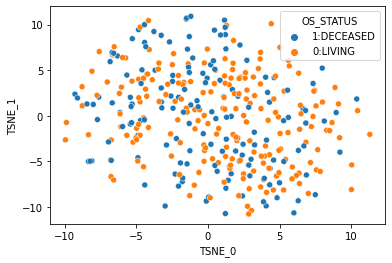

In [36]:
n_components = 2
df_plot = pd.DataFrame(dim_reduction(n_components).fit_transform(X_ae), columns=[dim_reduction_label.format(i) for i in range(n_components)])
df_plot = df_plot.join(df_clin.reset_index())
sns.scatterplot(data=df_plot, x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="OS_STATUS")
df_plot

## Integrating the Data With an Autoencoder

In [37]:
column_sizes = functools.reduce(lambda x,y: x+[x[-1]+y], [len(df.columns) for df in feature_dfs], [0])
column_sizes

[0, 16827]

In [38]:
d_in = X_ae.shape[-1]

ae = Autoencoder(
        input_dim = d_in,
        hidden_dims = [512],
        encoding_dim = 128,
        nonlinearity = F.relu,
        final_nonlinearity = lambda x:x,
        dropout_rate = 0.3,
        bias = True)

opt = torch.optim.Adam(ae.parameters(), lr=1e-3, weight_decay = 1e-4)

l1_weight = 1e-3

tX_ae = torch.tensor(X_ae, dtype=torch.float32)

epochs = 32
losses = []
for e in range(epochs):
    y = ae(tX_ae)
    acc = 0
    losses = [F.mse_loss(y[...,s:t], tX_ae[...,s:t]) for s,t in zip(column_sizes[:-1], column_sizes[1:])]
    l1_norm = l1_weight * sum((torch.norm(params, 1) for params in ae.parameters()))/len(list(ae.parameters()))
    loss = sum(losses) + l1_norm
    opt.zero_grad()
    loss.backward()
    opt.step()
    losses.append(loss)
    print(e, loss.detach().numpy())
ae.eval()
integrated_values = ae.encode(tX_ae).detach().numpy()

0 29.53936
1 27.527456
2 25.665043
3 23.987438
4 22.522661
5 21.239859
6 20.126482
7 19.205364
8 18.443985
9 17.671307
10 16.830414
11 15.968841
12 15.091398
13 14.241178
14 13.415702
15 12.6319475
16 11.900595
17 11.20953
18 10.57557
19 9.98526
20 9.406595
21 8.832115
22 8.255298
23 7.720379
24 7.1959963
25 6.7046447
26 6.2600684
27 5.83376
28 5.440147
29 5.0651693
30 4.7119474
31 4.370902


/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


,TSNE_0,TSNE_1,PATIENT_ID,OS_STATUS,OS_MONTHS,OS_STATUS_B
0,-2.582341,-8.059660,TCGA-60-2704-01,1:DECEASED,37.91,True
1,-8.817188,-6.589674,TCGA-77-A5G1-01,0:LIVING,132.26,False
2,0.544241,1.521519,TCGA-56-A4ZK-01,0:LIVING,18.73,False
3,4.877417,11.575747,TCGA-39-5027-01,0:LIVING,102.10,False
4,-4.586716,3.465715,TCGA-68-8250-01,0:LIVING,8.02,False
...,...,...,...,...,...,...
351,-9.735544,-0.387751,TCGA-34-5241-01,1:DECEASED,16.92,True
352,-1.397199,-1.942473,TCGA-O2-A52V-01,1:DECEASED,43.86,True
353,-3.742037,-8.655452,TCGA-68-A59I-01,0:LIVING,16.16,False
354,2.214849,-3.096654,TCGA-NC-A5HP-01,1:DECEASED,25.30,True


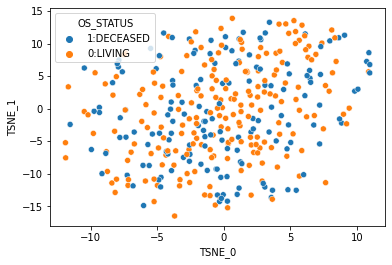

In [39]:
df_plot = pd.DataFrame(dim_reduction(n_components).fit_transform(integrated_values), columns=[dim_reduction_label.format(i) for i in range(n_components)])
df_plot = df_plot.join(df_clin.reset_index())
sns.scatterplot(data=df_plot, x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="OS_STATUS")
df_plot

### Find the Significant Factors  

In [40]:
# Set the threshold for significance
significance_threshold = 0.05

significant_factors_list = []
logRank_Pvalues_list = []

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    # logRank_Pvalues is a vector that will store the log-rank p-values of each 
    # univariate Cox-PH models built
    logRank_Pvalues = list()
    # significant_factors is a vector that will store every factor for which a 
    # significant Cox-PH model was built (log-rank P < 0.05)
    significant_factor_indexes = list()
    # Iterate over all factors/features of the actual dataframe
    for i in range(integrated_values.shape[1]):
        # Create a df with 3 columns, one for factor, one for OS_MONTHS
        # and one for OS_STATUS
        factor_df = pd.DataFrame(
            {
                "OS_MONTHS": df_clin["OS_MONTHS"].values,
                "OS_STATUS": df_clin["OS_STATUS_B"].values,
                "Factor_{}".format(i): integrated_values[:,i]
            }
        )
        # Build univariate COX-PH models
        cox_ph = lifelines.fitters.coxph_fitter.CoxPHFitter().fit(factor_df, "OS_MONTHS", "OS_STATUS")
        #log_rank_p_value = cox_ph.log_likelihood_ratio_test().p_value #summary["-log2(p)"][0]
        log_rank_p_value = cox_ph.summary["p"][0]
        if (log_rank_p_value<significance_threshold):
            significant_factor_indexes.append(i)
            logRank_Pvalues.append(log_rank_p_value)

    print("")
    print(significant_factor_indexes)
    print(logRank_Pvalues)


[4, 28, 29, 35, 48, 59, 72, 92, 97]
[0.039960289117277746, 0.015200116083845036, 0.03315559684876569, 0.022680750848356957, 0.027673601528450886, 0.03966578605171079, 0.036504443114800215, 0.048842827721704465, 0.026759647919068295]


In [41]:
significant_factors = integrated_values[:,significant_factor_indexes]
significant_factors

array([[ 1.4315899e-03,  3.0203375e-03, -3.9392528e-03, ...,
        -1.6862451e-03, -1.6056269e-02, -3.5415089e-03],
       [ 1.5425357e-03,  1.8727633e-03, -2.6505194e-03, ...,
        -3.3492551e-03, -1.4142158e-02, -6.4242515e-05],
       [ 1.6017125e-03,  5.8193924e-04, -2.2718983e-03, ...,
        -3.8170093e-03, -1.8696692e-02,  2.1825514e-03],
       ...,
       [ 2.7266617e-03,  3.2663713e-03, -2.2173852e-03, ...,
        -4.6026185e-03, -1.5239001e-02,  6.0389354e-04],
       [ 2.6677754e-03,  9.6752937e-04, -1.0379669e-03, ...,
        -2.5018784e-03, -1.6516939e-02, -8.3807390e-05],
       [ 9.5366384e-05,  1.4622184e-04, -2.5494951e-03, ...,
        -6.0921437e-03, -1.8953381e-02,  4.6787742e-03]], dtype=float32)

/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


,TSNE_0,TSNE_1,PATIENT_ID,OS_STATUS,OS_MONTHS,OS_STATUS_B
0,-3.889387,12.981378,TCGA-60-2704-01,1:DECEASED,37.91,True
1,0.065694,8.907843,TCGA-77-A5G1-01,0:LIVING,132.26,False
2,-5.665319,-7.077979,TCGA-56-A4ZK-01,0:LIVING,18.73,False
3,-1.619362,-5.194764,TCGA-39-5027-01,0:LIVING,102.10,False
4,-0.940523,3.039402,TCGA-68-8250-01,0:LIVING,8.02,False
...,...,...,...,...,...,...
351,12.390358,-4.127949,TCGA-34-5241-01,1:DECEASED,16.92,True
352,-3.748495,-2.660994,TCGA-O2-A52V-01,1:DECEASED,43.86,True
353,0.746582,8.108890,TCGA-68-A59I-01,0:LIVING,16.16,False
354,4.878195,-12.001042,TCGA-NC-A5HP-01,1:DECEASED,25.30,True


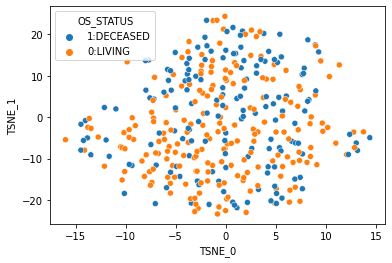

In [42]:
df_plot = pd.DataFrame(
    dim_reduction(n_components).fit_transform(significant_factors),
    #    if significant_factors.shape[-1] > 2 else
    #significant_factors,
    columns=[dim_reduction_label.format(i) for i in range(n_components)]
)    
df_plot = df_plot.join(df_clin.reset_index())
sns.scatterplot(data=df_plot, x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="OS_STATUS")
df_plot

### Working Back Features from Factors

## Cluster Samples

In [43]:
for k in range(2,6):
    kmeans = KMeans(k)
    kmeans.fit(significant_factors)
    labels = kmeans.labels_
    silhouette = silhouette_score(factor_df, labels)
    CH_score = calinski_harabasz_score(factor_df, labels)
    print("k="+str(k))
    print("Silhouette score:", silhouette)
    print("CH score", CH_score)
    print()

k=2
Silhouette score: 0.003145772029790799
CH score 1.841260965378054

k=3
Silhouette score: -0.029954079427059223
CH score 0.31747094761323447

k=4
Silhouette score: -0.06355236547379922
CH score 0.719458277330979

k=5
Silhouette score: -0.07737323188851528
CH score 0.3186447987197505



log-rank P value: 0.003354854127940622


<AxesSubplot:xlabel='timeline'>

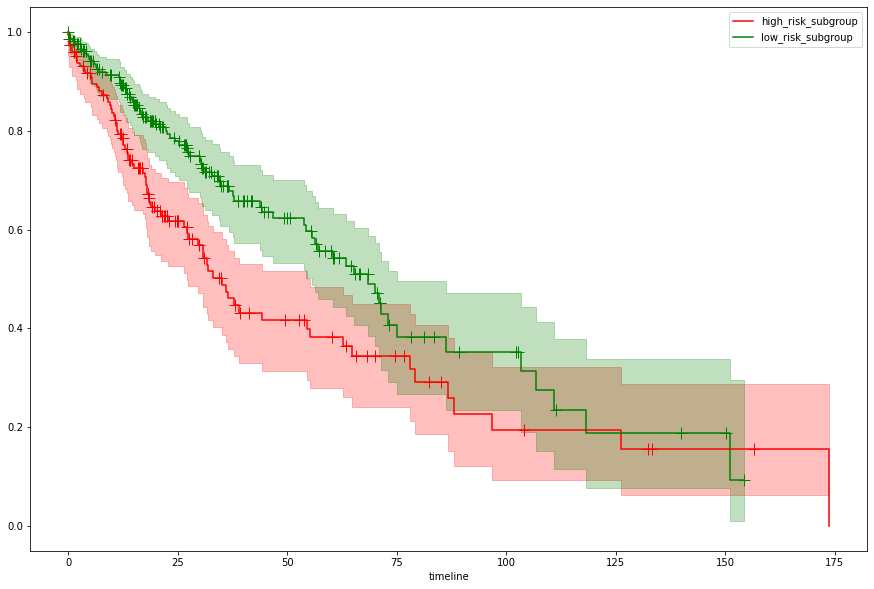

In [44]:
kmeans = KMeans(2).fit(significant_factors)
kmf_low, kmf_high, low_risk_samples, high_risk_samples = kmf_high_low(df_clin, kmeans.labels_)
# Compute the log-rank test P value between the 2 survival functions
results = lifelines.statistics.logrank_test(high_risk_samples["OS_MONTHS"], low_risk_samples["OS_MONTHS"],
                       high_risk_samples["OS_STATUS_B"], low_risk_samples["OS_STATUS_B"])
print("log-rank P value:",results.p_value)
plt.figure(figsize=(15,10))
kmf_high.plot(show_censors=1, ci_show=1, color="r")
kmf_low.plot(show_censors=1, ci_show=1, color="g")

log-rank P value: 0.9700004748377281


<AxesSubplot:xlabel='timeline'>

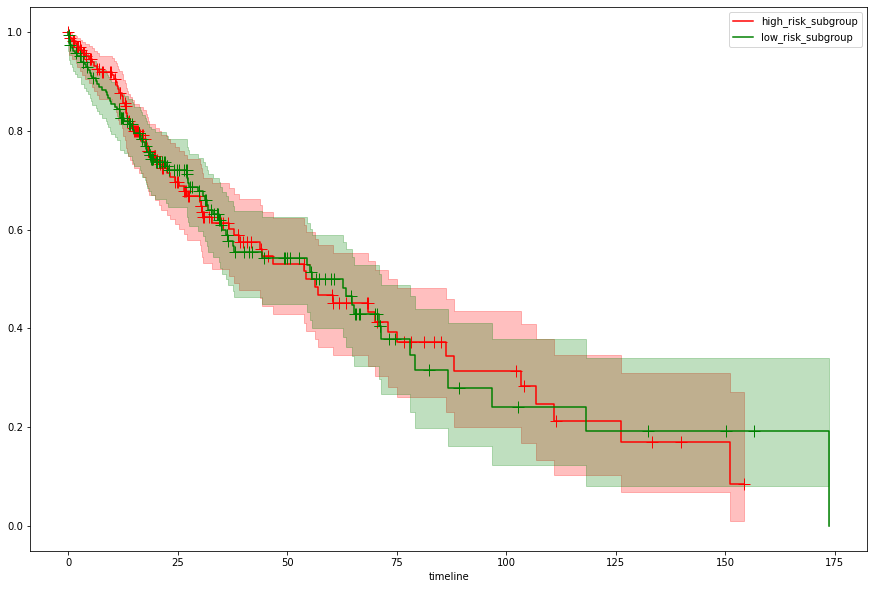

In [45]:
target_features = df_clin.copy()
kmf_low, kmf_high, low_risk_samples, high_risk_samples = kmf_high_low(df_clin, np.random.choice([0,1], size=df_clin.shape[0]))
# Compute the log-rank test P value between the 2 survival functions
results = lifelines.statistics.logrank_test(high_risk_samples["OS_MONTHS"], low_risk_samples["OS_MONTHS"],
                       high_risk_samples["OS_STATUS_B"], low_risk_samples["OS_STATUS_B"])
print("log-rank P value:",results.p_value)
plt.figure(figsize=(15,10))
kmf_high.plot(show_censors=1, ci_show=1, color="r")
kmf_low.plot(show_censors=1, ci_show=1, color="g")

In [46]:
target_features = df_clin.copy()
target_features["Risk_subgroup"] = kmeans.labels_
target_features

,OS_STATUS,OS_MONTHS,OS_STATUS_B,Risk_subgroup
PATIENT_ID,,,,
TCGA-60-2704-01,1:DECEASED,37.91,True,0
TCGA-77-A5G1-01,0:LIVING,132.26,False,0
TCGA-56-A4ZK-01,0:LIVING,18.73,False,1
TCGA-39-5027-01,0:LIVING,102.10,False,1
TCGA-68-8250-01,0:LIVING,8.02,False,0
...,...,...,...,...
TCGA-34-5241-01,1:DECEASED,16.92,True,1
TCGA-O2-A52V-01,1:DECEASED,43.86,True,1
TCGA-68-A59I-01,0:LIVING,16.16,False,0


In [47]:
df_mrna
df_lcna
df_methy
df_mirna

,hsa-mir-133a-1_mirna,hsa-mir-103a-2_mirna,hsa-mir-511_mirna,hsa-mir-664a_mirna,hsa-mir-6806_mirna,hsa-mir-508_mirna,hsa-mir-3199-2_mirna,hsa-mir-3074_mirna,hsa-mir-1270_mirna,hsa-mir-15a_mirna,...,hsa-mir-183_mirna,hsa-mir-199a-1_mirna,hsa-mir-151a_mirna,hsa-mir-3917_mirna,hsa-mir-153-2_mirna,hsa-mir-579_mirna,hsa-mir-4444-2_mirna,hsa-mir-767_mirna,hsa-mir-486-2_mirna,hsa-mir-4677_mirna
patient_id,,,,,,,,,,,,,,,,,,,,,
TCGA-60-2704-01,1.769935,13.143637,5.460828,4.354400,0.755898,4.688882,1.249363,2.583265,0.426899,6.990966,...,12.494808,11.369158,11.245911,2.035296,3.647939,0.755898,0.895963,5.466457,5.787477,3.411636
TCGA-77-A5G1-01,2.384260,14.357119,4.301453,5.179279,0.632765,3.772126,0.794141,2.528895,0.794141,8.388767,...,13.033357,10.594821,10.774841,0.451038,2.165660,0.632765,0.794141,8.803913,6.184933,4.328059
TCGA-56-A4ZK-01,1.825336,14.469559,4.805566,4.696560,0.000000,2.544338,0.326986,3.109643,0.326986,7.434356,...,13.321380,9.485020,11.124941,1.337048,2.544338,0.818171,0.593382,2.776306,4.894625,3.344548
TCGA-39-5027-01,2.054242,13.432582,3.965288,4.774664,1.443583,2.869182,1.839933,3.606408,1.443583,8.015174,...,15.607152,9.207580,12.243893,1.102078,1.951063,0.000000,0.653811,6.228013,9.347467,2.978164
TCGA-68-8250-01,3.379844,13.722138,5.103392,4.741104,0.916629,6.438820,0.438378,2.701268,0.916629,7.401990,...,14.015473,9.982868,12.463844,1.941346,2.620271,0.615999,0.916629,8.923873,8.161416,2.986238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-34-5241-01,2.325639,12.749261,4.463859,3.326103,0.586510,3.252078,0.000000,1.588056,1.002321,6.455796,...,13.169544,11.773028,11.466371,0.586510,3.911220,1.324713,0.000000,4.213841,4.935223,4.133656
TCGA-O2-A52V-01,1.419708,13.675480,4.765312,4.918474,0.383610,2.516353,0.816809,2.069814,0.686348,7.496359,...,13.359675,10.370068,10.648664,0.204518,3.229060,0.000000,0.000000,6.297808,6.720807,2.856856
TCGA-68-A59I-01,2.395695,14.148570,3.213174,4.946550,0.000000,2.758441,1.587744,2.462845,0.809144,6.934874,...,13.740942,10.548891,10.148507,0.586355,3.647694,1.002087,0.586355,4.573851,6.223283,2.395695


In [48]:
SelectKBest, f_classif

(sklearn.feature_selection._univariate_selection.SelectKBest,
 <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>)